# CorrDiff Style Residual Prediction with a Diffusion (EDM) Model
The models we've built so far produce relatively stable output. The "class" of the predictions is often correct, but the variance of the predictions is much lower than the variance present in the actual dataset. This is where generative modeling -- estimating and sampling from the underlying data disribution -- can be useful. Diffusion models are one such way to achieve this. We'll be using the design framework described in ["Elucidating the Design Space of Diffusion-Based Generative Models"](https://arxiv.org/abs/2206.00364) (Karras 2022).

In [1]:
import os
import datetime
import json
import time
from tqdm import tqdm 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.layers import DropPath
from torch.utils.data import Dataset, DataLoader
from accelerate import Accelerator, notebook_launcher

#local imports
from cnn_autoencoder import ConvAutoEncoder
from unet_denoiser import DenoisingUNet
from datasets import MNISTNextDigitResidualDataset
from diffusion_utils import EDMPrecond, EDMLoss, StackedRandomGenerator, edm_sampler


C:\Users\nimzo\miniconda3\envs\pytorch_tutorial\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\nimzo\miniconda3\envs\pytorch_tutorial\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## New Dataset for Residuals

Our (machine) learning objective has now changed. We are no longer trying to directly predict the image of the next digit. Instead, we will try to predict the residuals (i.e. the errors) of one of our previous models' predictions. This means we need a new Dataset class: **MNISTNextDigitResidualDataset**. The key features of this new class are:

- Instantiating requires a pretrained base model in addition to the train/test flag.
- Indexing will return a model prediction and residual pair. To get the original digit pair, just call `get_digits(idx)`.

## Denoiser Architecture

It's a unet+FiLM. TODO: explaim, draw a picture again

## EDM Training Quirks

From the *diffusion_utils.py* script, there are two classes required for training an EDM model:

- **EDMPrecond**

    - This is a wrapper around your denoising PyTorch model. Its main purpose is to apply the "preconditioning" scaling factors described in Section 5 of Karras 2022, the  derivations of which are described in Appendix B.6.

    - For practical use, the wrapped model *is* your denoising model. It only alters the behavior of your base denoising model when called to make a prediction.

- **EDMLoss**

    - Calling this class encapsulates more functionality than just computing a loss. It is responsible for determining the $\sigma$ level of a given sample (i.e. how much noise to add). Each $\sigma$ is drawn from a log-normal distribution, P, whose shape is determined by two hyperparameters (*P_mean* and *P_std*).
    - Once a $\sigma$ level is selected, noise from $\mathcal{N}(0,\sigma^2)$ is added to the clean image.
    - The denoiser is then asked to remove noise *entirely* from the image.
    - The mean squared error is computed between the true residuals and the denoised residuals.
    - This error is then scaled by another preconditioning factor (see Section 5 -- "Loss weighting and sampling" -- of Karras 2022 for a discussion) before being returned as the loss for that sample


## Define Training Parameters

In [3]:
#training configuration
batch_size = 128
learning_rate = 1e-3
num_epochs = 5
grad_clipnorm = 1 #gradients normed to this value (typically 1)
num_dataloader_workers = 2 # Number of separate processes to load data during training (2-8 usually sufficient)
gradient_accumulation_steps = 1 # Number of batches to run before adjusting weights. 1 typically, >1 if GPU memory limited
precision = "fp16" #always use float 16. Helps with speed and GPU memory

#load pre-trained "fuzzy" model
epoch = 4
model_name = "ConvAutoEncoder"
base_model = ConvAutoEncoder( #TODO: Encapsulate hyperparameters in picklable object
    n_input_channels = 1,
    n_output_channels = 1,
    n_conv_filters = [64, 64],
    n_layers_per_block = 3
)
checkpoint = torch.load(os.path.join(os.getcwd(), "models", "MNIST_num2num", "model_checkpoints", model_name,f"epoch{epoch}.pth"), weights_only=True)
base_model.load_state_dict(checkpoint['model_state_dict'])
base_model.eval()
base_model.to(("cuda"))

#load datasets
train_ds = MNISTNextDigitResidualDataset(base_model, is_train = True)
test_ds = MNISTNextDigitResidualDataset(base_model, is_train = False)

#put datasets into DataLoaders so PyTorch handles batches and shuffling
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

#set up our denoising model's architecture
denoiser = DenoisingUNet(
                 channels_in=1+1, # one channel for noise, the other for fuzzy conv model output
                 channels_out=1,
                 n_conv_filters=[32, 32, 32],
                 n_layers_per_block=3,
                 n_bottleneck_blocks=3,
                 cond_embedding_dim=16)

#wrap denoiser in the EDM preconditioner (a few fancy weights)
img_resolution = (28, 28)
num_label_channels = 1 #number of channels to be diffused
denoiser_wrapped =  EDMPrecond(img_resolution, num_label_channels, denoiser)

#create our optimizer and loss function
optimizer = torch.optim.Adam(denoiser_wrapped.parameters(), lr = learning_rate)
loss_function = EDMLoss(P_mean=0., P_std=1.2, sigma_data = 1.)

#create HuggingFace Accelerator object and wrap training components
accelerator = Accelerator(
    gradient_accumulation_steps = gradient_accumulation_steps, 
    mixed_precision = precision)

train_dataloader, test_dataloader, denoiser, optimizer = accelerator.prepare(train_dataloader, test_dataloader, denoiser_wrapped, optimizer)

## Training Loop

In [4]:
denoiser_name = "unet_denoiser"
#run our usual training loop
for epoch in range(num_epochs):

    denoiser.train()
    for batch_num, data in enumerate(tqdm(train_dataloader, leave = False)): #tqdm just makes nice progress bars
        with accelerator.accumulate(denoiser):

            X, y = data

            with accelerator.autocast():
                loss = loss_function(denoiser, y, X).mean()

            accelerator.backward(loss)
            if accelerator.sync_gradients: #included for multi-gpu training
                accelerator.clip_grad_norm_(denoiser.parameters(), grad_clipnorm) #prevents exploding gradients
                optimizer.step()
                optimizer.zero_grad()

    #if accelerator.is_main_process:
        #evaluate_model(model, loss_function, test_dataloader)
        #save_model_checkpoint(epoch, model, optimizer, loss, model_name = denoiser_name)

## Generating a Sample Using the Denoiser

TODO: Describe the Heun solver. Describe ODE vs SDE decision. Describe sigma step distribution.

## Plotting Results: TODO - tidy up

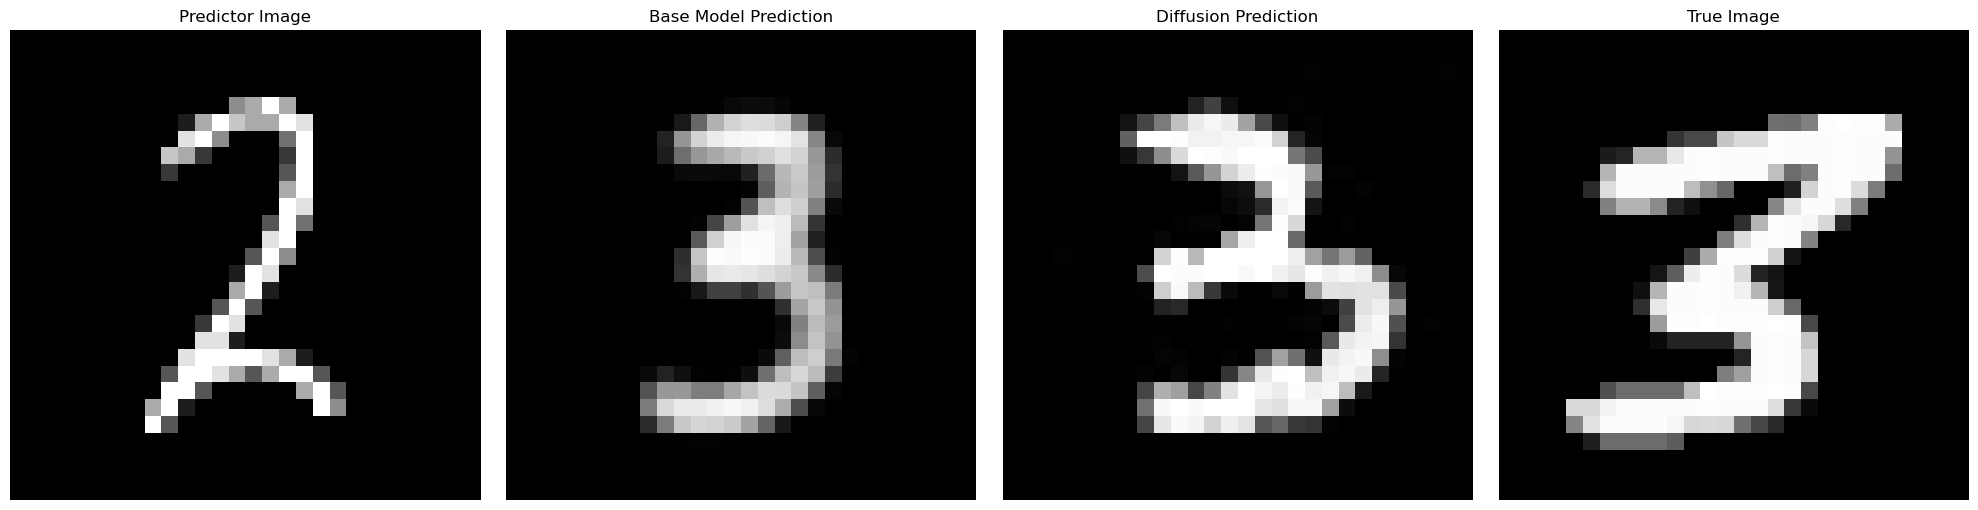

In [25]:
def plot_diff_pred(X, y, base_pred, diffusion_pred, save_name = None):
    """
    X, y, and pred are all numpy arrays of dimension (28, 28)
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(X.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[0].set_title(f"Predictor Image")
    axes[0].axis("off")
    axes[1].imshow(base_pred.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[1].set_title(f"Base Model Prediction")
    axes[1].axis("off")
    axes[2].imshow(base_pred.squeeze() - diffusion_pred.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[2].set_title(f"Diffusion Prediction")
    axes[2].axis("off")
    axes[3].imshow(y.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[3].set_title(f"True Image")
    axes[3].axis("off")
    plt.tight_layout()
    if save_name:
        plt.savefig(f"{save_name}.png")
    plt.show()

device = "cuda"
test_ds = MNISTNextDigitResidualDataset(base_model, is_train = False)
rnd = StackedRandomGenerator(device, [np.random.randint(1000)]) #device and seed of some random number
digit_idx = np.random.randint(20000)
X, y = test_ds.get_digits(digit_idx)
inputs, labels = test_ds[digit_idx] #fuzzy base model prediction and true residuals
inputs = torch.from_numpy(inputs[np.newaxis,...]).to(device)
latents = rnd.randn((1,) + labels.shape, device = device)
pred_residuals = edm_sampler(denoiser, latents, inputs, S_churn=0., num_steps = 18)

base_pred_np = inputs.cpu().numpy().squeeze()
pred_residuals_np = pred_residuals.cpu().numpy().squeeze()
#plt.imshow(pred_residuals_np, cmap = "RdBu", vmin = -1., vmax = 1.)

plot_diff_pred(X, y, base_pred_np, pred_residuals_np)

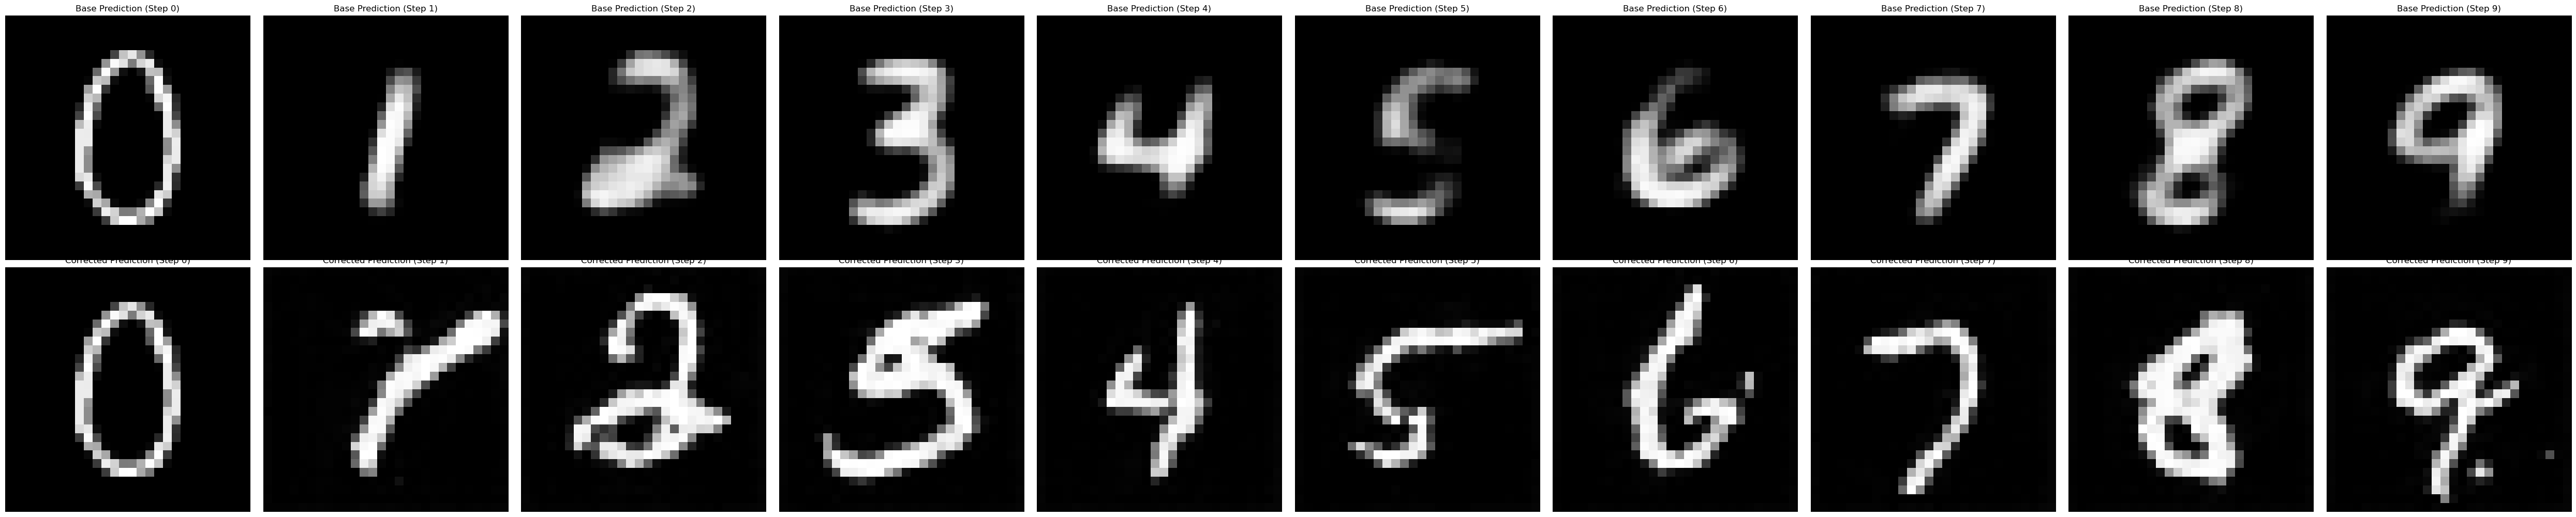

In [126]:
def plot_autoregressive_sequence_corrected(X, base_model, diffusion_model, edm_sampler, n_steps=3):
    """
    Runs autoregressive rollout with the base model, then corrects each prediction using diffusion residuals.

    :param X: numpy array - Original predictor image
    :param base_model: torch.nn.Module - Base predictive model
    :param diffusion_model: torch.nn.Module - Diffusion model for residual correction
    :param edm_sampler: function - EDM sampler to generate diffusion residuals
    :param n_steps: int - Number of autoregressive steps
    """
    device = next(base_model.parameters()).device  # Get model's device
    X_gpu = torch.from_numpy(X).unsqueeze(0).to(device, dtype=torch.float32)  # Ensure float32

    base_predictions = [X]  # Store base model predictions
    current_input = X_gpu

    # Step 1: Run base model autoregressive rollout
    with torch.no_grad():
        for _ in range(n_steps):
            base_pred = base_model(current_input).to(torch.float32)  
            base_pred_np = base_pred.cpu().numpy()
            base_predictions.append(base_pred_np)  # Store prediction

            # Use prediction as next input
            current_input = torch.from_numpy(base_pred_np).to(device, dtype=torch.float32)
            if current_input.dim() == 3:  
                current_input = current_input.unsqueeze(0)

    # Step 2: Apply diffusion correction to each base prediction
    corrected_predictions = [X]  # Start with original predictor
    with torch.no_grad():
        for base_pred_np in base_predictions[1:]:  # Skip the original X
            base_pred = torch.from_numpy(base_pred_np).to(device, dtype=torch.float32)
            s
            latents = torch.randn_like(base_pred, dtype=torch.float32, device=device)  # Ensure float32
            pred_residuals = edm_sampler(diffusion_model, latents, base_pred, S_churn=0., num_steps=18).to(torch.float32)
            pred_residuals_np = pred_residuals.cpu().numpy()

            corrected_pred_np = base_pred_np - pred_residuals_np  # Apply correction
            corrected_predictions.append(corrected_pred_np)

    # Step 3: Plot results
    n_cols = n_steps + 1  # Original + n_steps
    fig, axes = plt.subplots(2, n_cols, figsize=(5 * n_cols, 10))

    # Plot base model predictions
    for i in range(n_cols):
        axes[0, i].imshow(base_predictions[i].squeeze(), cmap="gray", vmin=0., vmax=1.)
        axes[0, i].set_title(f"Base Prediction (Step {i})")
        axes[0, i].axis("off")

    # Plot corrected predictions
    for i in range(n_cols):
        axes[1, i].imshow(corrected_predictions[i].squeeze(), cmap="gray", vmin=0., vmax=1.)
        axes[1, i].set_title(f"Corrected Prediction (Step {i})")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

plot_autoregressive_sequence_corrected(X, base_model, denoiser, edm_sampler, n_steps=9)